In [3]:
import yt
import numpy as np
import json

In [4]:
yt.enable_plugins()

yt : [INFO     ] 2023-01-24 09:54:20,518 Loading plugins from /home/dskinner6/.config/yt/my_plugins.py


In [5]:
run_dir = '../'
data_dir = 'run_data/'
image_outputs = 'images/'

tiny_number = 1e-30

stars = ['p3_age', 'p3_binary', 'ns_binary', 'bh', 'p2', 'dm']
types = [5, 12, 13, 6, 7, 1]

In [6]:
with open('run_DD_data.json') as f:
    DD_data = json.load(f)
    
with open('star_info.json') as f:
    star_info = json.load(f)
    
with open('run_halos_incl_vir.json') as f:
    run_halos = json.load(f)

In [7]:
dataset_list = []

for i, run_name in enumerate(star_info):
    for j, o in enumerate(star_info[run_name]):
        if star_info[run_name][o]['star_info']['chosen_star']['id'] != -1:
            dataset_list.append(f'{run_dir}{run_name}/DD{o}/output_{o}')

        else:
            star_info[run_name][o]['star_info']['chosen_star']['velocity'] = -1

In [11]:
with open('star_info_with_vel.json', 'w') as f:
    json.dump(star_info, f)

In [9]:
fns = yt.DatasetSeries(dataset_list)

In [12]:
star_info_temp = {}

for sto, ds in fns.piter(storage = star_info_temp, dynamic = True):
    run_name = str(ds.directory).split('/')[-2]
    
    o = str(ds).split('output_')[-1]
    
    temp_dict = {}
    temp_dict[run_name] = {}
    temp_dict[run_name][o] = {}
    
    ident = star_info[run_name][o]['star_info']['chosen_star']['id']
    #ds = yt.load(f'{run_dir}{run_name}/DD{o}/output_{o}')
    ds.add_particle_filter('p3')
    ad = ds.all_data()
    
    p3_id = np.array(ad['all', 'particle_index'])
    where_p3 = np.argwhere(p3_id == ident)[0][0]

    p3_vel = ad['all', 'particle_velocity'][where_p3].v.tolist()
    
    temp_dict[run_name][o]['chosen_vel'] = p3_vel
    
    sto.result_id = run_name + '_' + o
    sto.result = temp_dict

yt : [INFO     ] 2023-01-24 10:04:33,590 Parameters: current_time              = 33.27075988951
yt : [INFO     ] 2023-01-24 10:04:33,590 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2023-01-24 10:04:33,591 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-24 10:04:33,592 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-24 10:04:33,592 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-01-24 10:04:33,592 Parameters: current_redshift          = 20.111978616284
yt : [INFO     ] 2023-01-24 10:04:33,593 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2023-01-24 10:04:33,593 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2023-01-24 10:04:33,593 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-01-24 10:04:33,593 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|████████████████████████████████████████████████████████████████████████████

KeyboardInterrupt: 

In [34]:
with open('star_info_with_vel.json', 'r') as f:
    star_info_vel = json.load(f)
    
with open('star_info_temp.json', 'r') as f:
    star_info_temp = json.load(f)    

In [41]:
for i, run_name in enumerate(star_info_vel):
    for j, o in enumerate(star_info_vel[run_name]):
        vel_present = 'velocity' in star_info_vel[run_name][o]['star_info']['chosen_star'].keys()
        if vel_present == False:
            key_name = run_name + '_' + o
            star_info_vel[run_name][o]['star_info']['chosen_star']['velocity'] = star_info_temp[key_name][run_name][o]['chosen_vel']

In [44]:
with open('star_info_vel.json', 'w') as f:
    json.dump(star_info_vel, f)

In [49]:
vary_energy = ['run_original', 'run_fiducial', 'run_D', 'run_E']
vary_time = ['run_original', 'run_fiducial', 'run_A', 'run_B']
with open('param_info.json') as f:
    param_info = json.load(f)
    

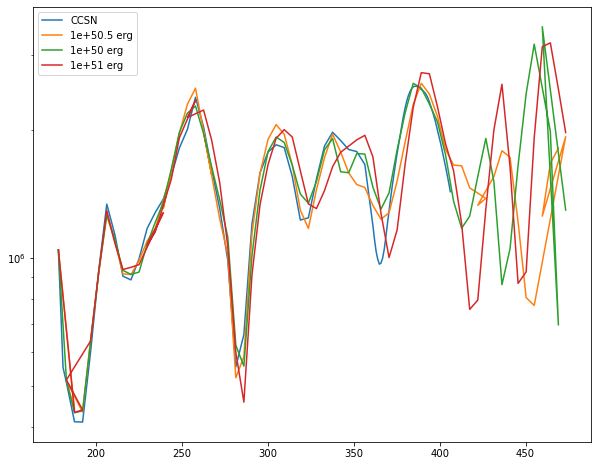

In [52]:
fig = plt.figure(figsize=(10, 8))
for i, run_name in enumerate(vary_energy):
    
    if run_name != 'run_original':
            run_label = param_info[run_name]['energy'] + ' erg'
    else:
        run_label = 'CCSN'
        
    vel_mag = []
    time = []
    
    for j, o in enumerate(star_info_vel[run_name]):
        if star_info_vel[run_name][o]['star_info']['chosen_star']['velocity'] != -1:
            velocity = star_info_vel[run_name][o]['star_info']['chosen_star']['velocity']
            vx = velocity[0]
            vy = velocity[1]
            vz = velocity[2]
            
            total_v = np.sqrt((vx**2) + (vy**2) + (vz**2))
            vel_mag.append(total_v)
            
            time.append(DD_data[run_name][o]['time'])
    
    vel_mag = np.array(vel_mag)
    time = np.array(time)
    
    plt.plot(time, vel_mag, label = run_label)
            
    
plt.yscale('log')      
plt.legend()